In [1]:
#import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import nltk
import ssl
import re
import sklearn
from sklearn import feature_selection, feature_extraction, naive_bayes, pipeline, metrics
import transformers
from transformers import AutoTokenizer
import torch
import gc
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

2022-04-28 12:21:31.089217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-28 12:21:31.089311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#load data
df = pd.read_csv('spectrum.csv')
df = df.dropna()
df = df[['spectrum', 'body']]

#split data 
train, test = sklearn.model_selection.train_test_split(df, test_size=0.3, random_state=1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [3]:
#tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [4]:
#model
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [5]:
#tokenizer function
@torch.no_grad()
def tokenizer_func(data):
    text = [i[0] for i in data]
    labels = torch.tensor([i[1] for i in data])
    tokened = tokenizer(text,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')
    return tokened, labels

In [6]:
#dataset for torch
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data):
        
        self.labels = [1 if x == 'right' else 0 for x in data['spectrum'].values]
        self.dataframe = data

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]
    
    def __getitem__(self, idx):

        texts = self.dataframe.iloc[idx]['body']
        labels = self.labels[idx]

        return texts, labels

In [21]:
#create torch dataset for train
train_data = Dataset(train)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=300,
                                               shuffle=True,
                                               collate_fn=tokenizer_func)

In [22]:
# freeze all layers except classifiers to speed up training - fine tuning
for p in model.parameters():
    p.requires_grad = False

for p in model.classifier.parameters():
    p.requires_grad = True

for p in model.pre_classifier.parameters():
    p.requires_grad = True

model.eval()
model.classifier.train()
model.pre_classifier.train()

In [23]:
#train model
def trainer(model, train_dataloader, learning_rate, epochs):
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for i, (train_input, train_label) in enumerate(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            model.zero_grad()
            output = model(input_id, mask)

            batch_loss = criterion(output.logits, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.logits.argmax(dim=1) == train_label).sum().item() / len(
                train_label
            )
            if i % 10 == 0:
                print(i, acc)
            total_acc_train += acc
            
            batch_loss.backward()
            optimizer.step()

        print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_input): .3f} \
        | Train Accuracy: {total_acc_train / len(train_input): .3f}')

                  
EPOCHS = 2
model = model
LR = 1e-4
              
trainer(model, train_dataloader, LR, EPOCHS)

100%|█████████████████████████████████████████████| 3/3 [00:56<00:00, 18.88s/it]

Epochs: 1 | Train Loss:  0.713             | Train Accuracy:  11.667


In [ ]:
#save model
model = model.cpu()
model = model.eval()
torch.save(model.state_dict(), "modeltrained2.pt")
exit(1)

In [7]:
#load model
#model = transformers.AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
#model.load_state_dict(torch.load('modeltrained.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

<All keys matched successfully>

In [9]:
#create torch dataset for test
test_data = Dataset(test.sample(20))

test_dataloader = torch.utils.data.DataLoader(test_data, 
                                               batch_size=20,
                                               shuffle=True,
                                               collate_fn=tokenizer_func)

In [10]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    pred_labels = []
    y_labels = []
    y_prob = []
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            pred_labels += output.logits.argmax(dim=1).tolist()
            y_labels += test_label.tolist()
            y_prob += nn.functional.softmax(output.logits, dim=1)
    
    return(pred_labels, y_labels, y_prob)
    
test_pred_labels, test_y_labels, test_y_prob = evaluate(model, test_dataloader)

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


In [ ]:
#save results
#torch.save(test_pred_labels, 'test_pred_labels.pt')
#torch.save(test_y_labels, 'test_y_labels.pt')
#torch.save(test_y_prob, 'test_y_prob.pt')

In [14]:
#load results
#test_pred_labels = torch.load('test_pred_labels.pt')
#test_y_labels = torch.load('test_y_labels.pt')
#test_y_prob = torch.load('test_y_prob.pt')

Accuracy: 0.7
Auc: 0.77
Detail:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     29799
           1       0.69      0.72      0.70     29775

    accuracy                           0.70     59574
   macro avg       0.70      0.70      0.70     59574
weighted avg       0.70      0.70      0.70     59574



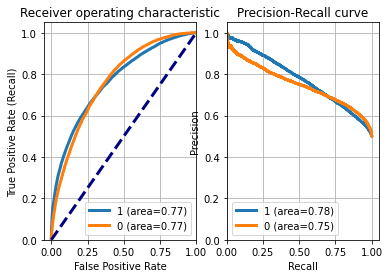

In [15]:
#print results
classes = [1,0]
y_test_array = pd.get_dummies(test_y_labels, drop_first=False).values
test_y_prob = torch.stack(test_y_prob)

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(test_y_labels, test_pred_labels)
auc = metrics.roc_auc_score(test_y_labels, test_y_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(test_y_labels, test_pred_labels))

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           test_y_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], test_y_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()